In [108]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cyberbullying:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4424745%2F7600853%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240212%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240212T094655Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4de985e9051700e62b8b8d91dc9ec2b24842e643264d51f2c2fcf9065df91f6cdc52504d6fac9ca34934e142de861880aa1be761dce378c116bc2d7d40b8e70a7a84f6ea6a470dda5a53474e4b05320b38cbb5519822d9e004599da5f8f45972c21fa6645ba7e75504e5181e484c098f11398a53a4b2445c21288850b0c4ee2f9aef5e23e45938728ab3d78df8f61a5ecdec8b5e0eee54909e0a79be469ffc888663a02e15e7f2f17d8f73043596138aa02924d824f8a7938827500766af4104a3e1e3cd3c39814fff29bc6c0bfe188b0c3302ad58c054942c2886e7d819c98cd3cf5688d197b1d5a1bcc9e9207ad914ce44e68c6c4df6e95e372680958861f7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1038341 bytes downloaded
Downloaded and uncompressed: cyberbullying
Data source import complete.


In [109]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyberbullying/twitter_parsed_dataset.csv


## Import the required library

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


import re
import string
from wordcloud import WordCloud

from textblob import TextBlob

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec

from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import Adam

import transformers
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TextClassificationPipeline)

import joblib
from tqdm import tqdm

import contractions

import data

In [111]:
df = pd.read_csv("/kaggle/input/cyberbullying/twitter_parsed_dataset.csv")

In [112]:
df.head()

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [113]:
df = df.drop(columns=['index', 'id', 'Annotation'], axis = 1)

In [114]:
df.columns = ['text', 'label']

In [115]:
df.head()

,text,label
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0
4,#mkr No No No No No No,0.0


In [116]:
df['label'].unique()

array([ 0.,  1., nan])

In [117]:
df['text'][0]

'@halalflaws @biebervalue @greenlinerzjm I read them in context.No change in meaning. The history of Islamic slavery. https://t.co/xWJzpSodGj'

## Exploratory Data Anaysis

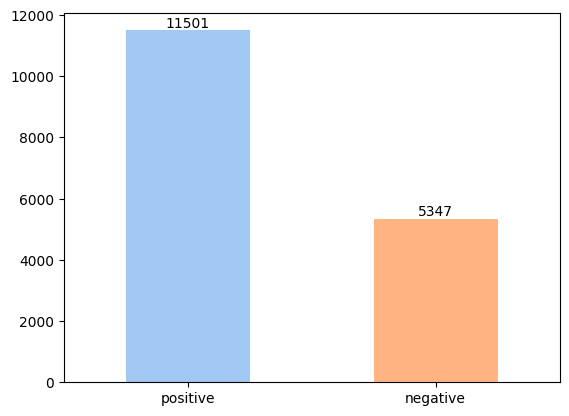

In [118]:
df['label'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

# Add count annotations on top of each bar
ax = plt.gca()  # Get the current AxesSubplot
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height()}', ha='center', va='bottom')

plt.xticks([0, 1], ['positive', 'negative'], rotation=0)
plt.show()

In [119]:
nltk.download('words')
only_english = set(nltk.corpus.words.words())
def clean_text(text):

    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = " ".join([contractions.fix(x) for x in sample.split()])  # fixes contractions like you're to you are
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes

    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english

    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])

    return sample

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [120]:
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(str(x)))
df

,text,label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...
4,#mkr No No No No No No,0.0,mkr no no no no no no
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked


cleaning dataset

In [121]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def get_wordnet_pos(word):

    treebank_tag = nltk.pos_tag([word])[0][1]

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text

    sample = text

    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)

    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
        sample = ' '.join(sample)

    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)

    if spell:
        sample = str(TextBlob(text).correct())

    return sample

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
df['correct_text'] = 'text'
df

,text,label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,text
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,text
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,text
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,text
4,#mkr No No No No No No,0.0,mkr no no no no no no,text
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,text
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,text
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,text
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,text


In [123]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
count = 0
for text in tqdm(df['cleaned_text']):
    df['correct_text'][count] = correct_text(text, lemma=True)
    count += 1

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
  0%|          | 0/16851 [00:00<?, ?it/s]<ipython-input-123-c35fdbc7797a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct_text'][count] = correct_text(text, lemma=True)
100%|██████████| 16851/16851 [00:32<00:00, 523.42it/s]


In [124]:
df['word_count'] = df['correct_text'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['correct_text'].str.len() ## this also includes spaces

In [125]:
df

,text,label,cleaned_text,correct_text,word_count,char_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,read context change meaning history islamic sl...,7,51
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,idiot claim people try stop become terrorist m...,12,82
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,rt call sexist go auto place would rather talk...,10,50
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,wrong isi follow example mohammed quran exactly,7,47
4,#mkr No No No No No No,0.0,mkr no no no no no no,mkr,1,3
...,...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,feel sorry girl safe kat andre go home mkr,9,42
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,mkr pretty good dish happy ok well never eat p...,10,50
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,rt deconstruct lemon tart please go one season...,14,93
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block,3,17


<Axes: >

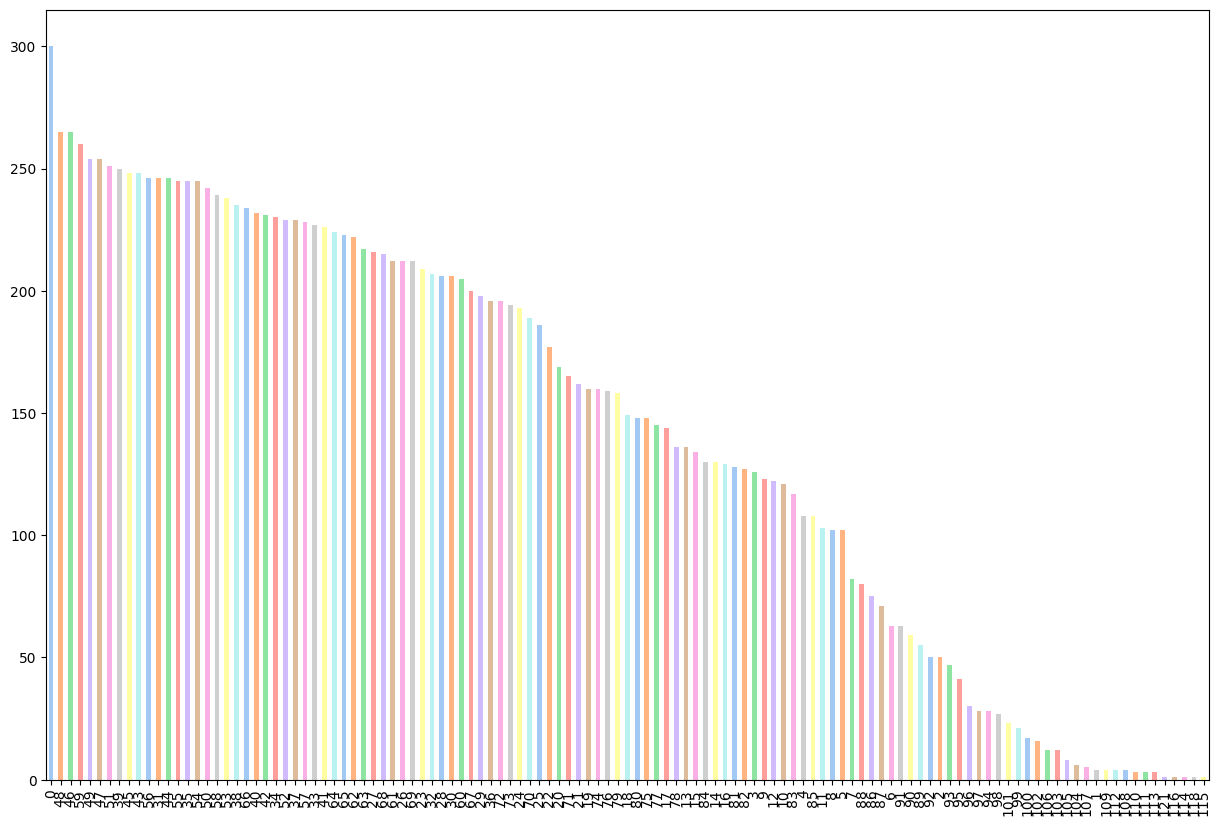

In [126]:
plt.figure(figsize=(15,10))
df['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [127]:
df = df[~(df['char_count'] == 0)].reset_index(drop=True)

In [128]:
df[(df['label']==0)]

,text,label,cleaned_text,correct_text,word_count,char_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,read context change meaning history islamic sl...,7,51
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,idiot claim people try stop become terrorist m...,12,82
4,#mkr No No No No No No,0.0,mkr no no no no no no,mkr,1,3
5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,rt saudi preacher who raped and tortured his f...,rt saudi preacher rap torture five year old da...,11,66
7,Going to make some pancakes.....Don't hve any ...,0.0,going to make some pancakes do not hve any str...,go make pancake hve strawberry hve banana mkr,8,45
...,...,...,...,...,...,...
16546,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,feel sorry girl safe kat andre go home mkr,9,42
16547,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,mkr pretty good dish happy ok well never eat p...,10,50
16548,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,rt deconstruct lemon tart please go one season...,14,93
16549,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block,3,17


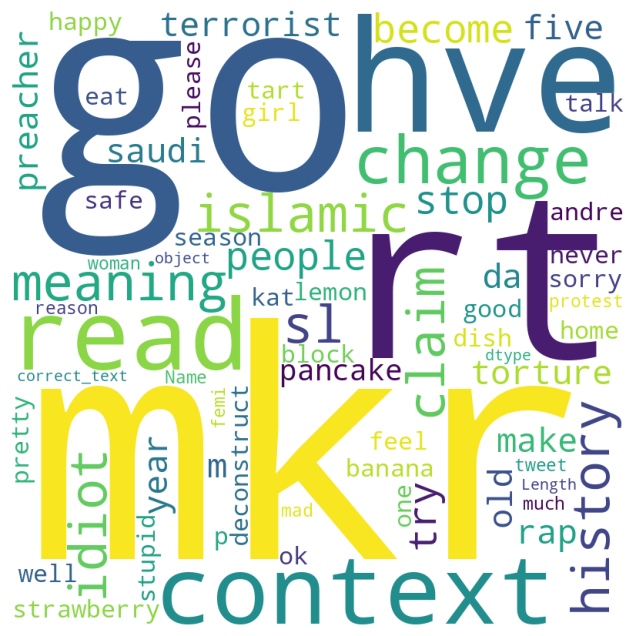

In [129]:
g = str(df[df['label']== 0]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
#plt.tight_layout(pad = 0)

plt.show()

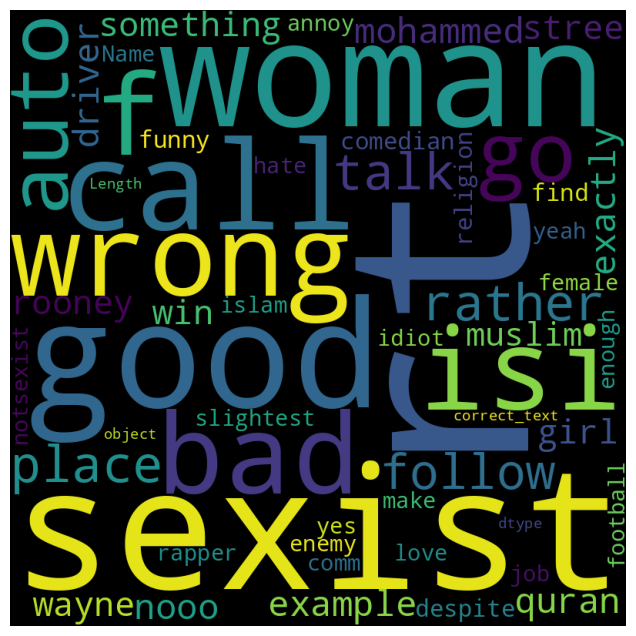

In [130]:
g = str(df[df['label']==1]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
#plt.tight_layout(pad = 0)

plt.show()

In [131]:
final_df = df.drop(columns = ['text', 'cleaned_text', 'word_count', 'char_count'])
final_df.to_csv("cleaned_df.csv", index=False)

In [132]:
final_df

,label,correct_text
0,0.0,read context change meaning history islamic sl...
1,0.0,idiot claim people try stop become terrorist m...
2,1.0,rt call sexist go auto place would rather talk...
3,1.0,wrong isi follow example mohammed quran exactly
4,0.0,mkr
...,...,...
16546,0.0,feel sorry girl safe kat andre go home mkr
16547,0.0,mkr pretty good dish happy ok well never eat p...
16548,0.0,rt deconstruct lemon tart please go one season...
16549,0.0,stupid talk block


In [133]:
# load doc and add to vocab
def build_vocab(vocab_obj, text):
    sample = text
    tokens = [word for word in sample.split()]
    vocab_obj.update(tokens)

def save__vocab_list(vocab, filename):
    lines = [a for a in vocab.keys()]
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w', encoding="utf-8")
    # write text
    file.write(data)
    # close file
    file.close()


In [134]:
vocab = Counter()
for text in final_df['correct_text']:
    build_vocab(vocab, text)

In [135]:
print(vocab.most_common(50))

[('mkr', 4941), ('rt', 3683), ('woman', 1236), ('kat', 1104), ('sexist', 1095), ('get', 1064), ('like', 1043), ('go', 991), ('islam', 926), ('muslim', 793), ('would', 747), ('people', 742), ('make', 707), ('amp', 691), ('one', 670), ('say', 626), ('think', 618), ('girl', 595), ('cannot', 555), ('know', 554), ('andre', 548), ('want', 526), ('see', 517), ('time', 482), ('isi', 481), ('look', 466), ('well', 453), ('call', 446), ('fuck', 428), ('really', 400), ('good', 398), ('men', 383), ('need', 379), ('thing', 372), ('right', 360), ('even', 322), ('oh', 305), ('way', 303), ('give', 303), ('u', 303), ('take', 303), ('talk', 300), ('female', 294), ('never', 291), ('bad', 290), ('use', 287), ('try', 285), ('year', 285), ('hate', 281), ('show', 278)]


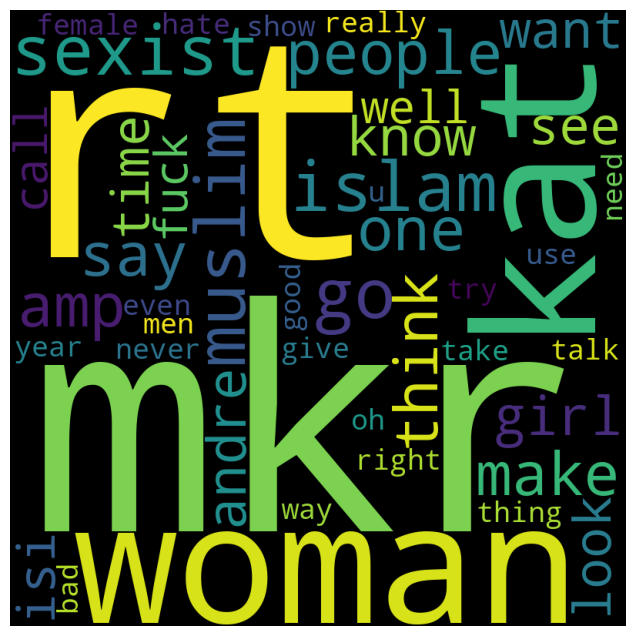

In [136]:
g = " ".join([x[0] for x in vocab.most_common(50)])

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
#plt.tight_layout(pad = 0)

plt.show()

## Model Eveluation

In [137]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

#  define the model
def define_model(vocab_size, max_length, n_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Flatten(input_shape=(n_words,)))
    model.add(Dense(45, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


In [138]:
X = final_df['correct_text']
y = final_df['label']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=99)

In [140]:
X_train.fillna(" ", axis=0, inplace=True)
X_test.fillna(" ", axis=0, inplace=True)
y_train.fillna(0.0, inplace=True)
y_test.fillna(1.0, inplace=True)

In [141]:
vocab_set = set([x for x in vocab if len(x)>2])

tokenizer = create_tokenizer(X_train.values)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in X_train])

In [142]:
x_train = encode_docs(tokenizer, max_length, X_train.values)
x_test = encode_docs(tokenizer, max_length, X_test.values)

In [143]:
clf_model = define_model(vocab_size, max_length, x_train.shape[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 100)           1066900   
                                                                 
 flatten_2 (Flatten)         (None, 2300)              0         
                                                                 
 dense_4 (Dense)             (None, 45)                103545    
                                                                 
 dense_5 (Dense)             (None, 1)                 46        
                                                                 
Total params: 1170491 (4.47 MB)
Trainable params: 1170491 (4.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [144]:
clf_model.fit(x_train, y_train.values, epochs=10, verbose=2, batch_size=74)

Epoch 1/10
157/157 - 4s - loss: 0.6255 - accuracy: 0.6767 - 4s/epoch - 24ms/step
Epoch 2/10
157/157 - 3s - loss: 0.5829 - accuracy: 0.6962 - 3s/epoch - 22ms/step
Epoch 3/10
157/157 - 3s - loss: 0.5149 - accuracy: 0.7715 - 3s/epoch - 20ms/step
Epoch 4/10
157/157 - 3s - loss: 0.4330 - accuracy: 0.8185 - 3s/epoch - 17ms/step
Epoch 5/10
157/157 - 2s - loss: 0.3668 - accuracy: 0.8472 - 2s/epoch - 16ms/step
Epoch 6/10
157/157 - 3s - loss: 0.3173 - accuracy: 0.8730 - 3s/epoch - 16ms/step
Epoch 7/10
157/157 - 4s - loss: 0.2783 - accuracy: 0.8913 - 4s/epoch - 26ms/step
Epoch 8/10
157/157 - 2s - loss: 0.2444 - accuracy: 0.9076 - 2s/epoch - 15ms/step
Epoch 9/10
157/157 - 2s - loss: 0.2147 - accuracy: 0.9208 - 2s/epoch - 15ms/step
Epoch 10/10
157/157 - 3s - loss: 0.1878 - accuracy: 0.9339 - 3s/epoch - 17ms/step


In [145]:
clf_model.evaluate(x_train, y_train, verbose=0)[1]

0.9464825391769409

In [146]:
clf_model.evaluate(x_test, y_test, verbose=0)[1]

0.8248087167739868

In [147]:
clf_model.predict(x_test[0].reshape(1,-1))[0,0]

1/1 [==============================] - 0s 107ms/step


0.94256717

In [148]:
def predict_sentiment(text, vocab=vocab_set, tokenizer=tokenizer, max_length=max_length, model=clf_model):
    line = text
    line = clean_text(line)
    line = correct_text(line)
    line = " ".join([word for word in line.split() if word in vocab])
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'


In [149]:
predict_sentiment(final_df['correct_text'][200], vocab_set, tokenizer, max_length, clf_model)

(0.968397106975317, 'NEGATIVE')

In [161]:
clf_model.save('clf_seq.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [153]:
X_test

10263             kat football head see head want kick mkr
5804           rt thepommies mkr swear quote one direction
3587                rt questionsformen know look girl rape
5603            doj quote small sample survey already cite
8792                 annie lloyd sudden death surprise mkr
                               ...                        
8962     logie disgust person tv kat much joy win play ...
505                           million african murder islam
11821    basically claim religion teach hatred murder n...
10303    ivantrba least promogirls might future create ...
2481                             prison except prison time
Name: correct_text, Length: 4966, dtype: object

In [154]:
y_test

10263    1.0
5804     0.0
3587     1.0
5603     0.0
8792     0.0
        ... 
8962     0.0
505      1.0
11821    1.0
10303    1.0
2481     1.0
Name: label, Length: 4966, dtype: float64